<a href="https://colab.research.google.com/github/aml7hawaiiedu/CCAPLandCoverProject/blob/main/Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages('gdalutils')
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘gdalutils’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this packag

# New Section

In [181]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI)
library(zip)

In [6]:
# https://drive.google.com/file/d/1DByagFnHZbFeMyGtVSBj1biXkAy0h__w/view?usp=drive_link
drive_download(file = as_id('1DByagFnHZbFeMyGtVSBj1biXkAy0h__w'), path =  '/content/CCAP/Niihau_2005_CCAP.tif', overwrite = TRUE)

# https://drive.google.com/file/d/1V78JNUFb6bgA2wrwqY2EelF5On7C5Uo3/view?usp=drive_link
drive_download(file = as_id('1V78JNUFb6bgA2wrwqY2EelF5On7C5Uo3'), path =  '/content/CCAP/Niihau_2005_LS.tif', overwrite = TRUE)

File downloaded:

• hi_niihau_2005_ccap_hr_land_cover.img <id: 1DByagFnHZbFeMyGtVSBj1biXkAy0h__w>

Saved locally as:

• /content/CCAP/Niihau_2005_CCAP.tif

File downloaded:

• 7.tif <id: 1V78JNUFb6bgA2wrwqY2EelF5On7C5Uo3>

Saved locally as:

• /content/CCAP/Niihau_2005_LS.tif



In [7]:
ccap_raster <- stack('/content/CCAP/Niihau_2005_CCAP.tif')
ls_raster <- stack('/content/CCAP/Niihau_2005_LS.tif')

In [111]:
ls_raster_extended <- extend(ls_raster, projectExtent(ccap_raster,ls_raster), value=NA)

In [8]:
ccap_raster
ls_raster

class      : RasterStack 
dimensions : 14683, 11146, 163656718, 1  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 366932.4, 393682.8, 2402029, 2437268  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=4 +datum=NAD83 +units=m +no_defs 
names      : names 
min values :     0 
max values :    21 


class      : RasterStack 
dimensions : 1089, 1013, 1103157, 9  (nrow, ncol, ncell, nlayers)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -160.2868, -160.0138, 21.74471, 22.03819  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : B1, B2, B3, B4, B5, B6, B7, B10, B11 


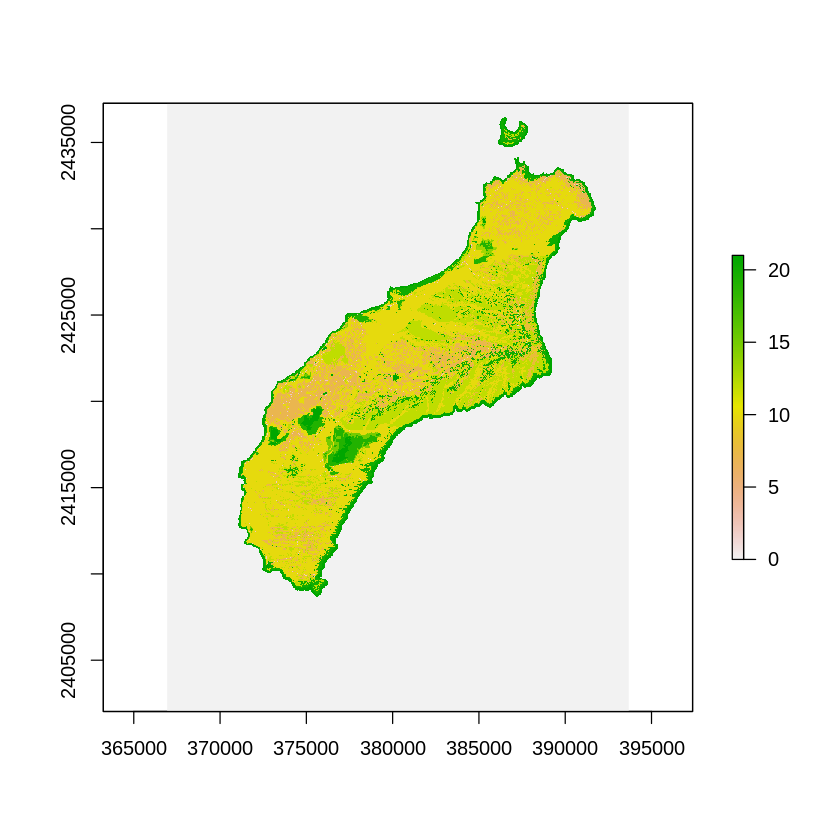

In [9]:
ccap_raster %>% plot

In [134]:
ncol(ccap_raster)

nrow(ccap_raster)


y_end <- c(seq(1,ccap_raster %>% nrow,512),nrow(ccap_raster))[-1]
x_end <- c(seq(1,ccap_raster %>% ncol,512),ncol(ccap_raster))[-1]

extract_grid <- expand.grid(x_end,y_end) %>% data.table

names(extract_grid) <- c('x_end','y_end')

extract_grid$x_org <- extract_grid$x_end - 512
extract_grid$y_org <- extract_grid$y_end - 512

extract_grid$id <- 1:nrow(extract_grid)

[1] 11146

[1] 14683

[1]   513  1025  1537  2049  2561  3073  3585  4097  4609  5121  5633  6145
[13]  6657  7169  7681  8193  8705  9217  9729 10241 10753 11146

[1]   513  1025  1537  2049  2561  3073  3585  4097  4609  5121  5633  6145
[13]  6657  7169  7681  8193  8705  9217  9729 10241 10753 11265 11777 12289
[25] 12801 13313 13825 14337 14683

In [179]:
result_dt <-
1:nrow(extract_grid) %>% lapply(function(x){

  nrow <- 0
  ncol <- 0
  i <- 0
  while(nrow !=512 | ncol != 512){
    i <- i + 1
    # Calculate the geographic coordinates for the cropping extent
    xmin <- xFromCol(ccap_raster, extract_grid[x,]$x_org) + rnorm(1)*.01*2.4
    xmax <- xFromCol(ccap_raster, extract_grid[x,]$x_end) + rnorm(1)*.01*2.4
    ymin <- yFromRow(ccap_raster, extract_grid[x,]$y_end) + rnorm(1)*.01*2.4 # Note row_max as raster origin is top-left
    ymax <- yFromRow(ccap_raster, extract_grid[x,]$y_org) + rnorm(1)*.01*2.4 # Note row_min as raster origin is top-left

    e <- extent(xmin, xmax, ymin, ymax)

    ccap_cropped_raster <- crop(ccap_raster, e)

    nrow <- nrow(ccap_cropped_raster)
    ncol <- ncol(ccap_cropped_raster)


    # print(dim(ccap_cropped_raster))
    if(i>1000){return('failed to converge')}
    }

  ls_cropped_raster <- crop(ls_raster_extended, projectExtent(ccap_cropped_raster,ls_raster))

  ls_resampled_raster <- projectRaster(ls_cropped_raster,ccap_cropped_raster)
  print(ls_resampled_raster)
  pixel_table <- (table(values(ccap_cropped_raster))/ncell(ccap_cropped_raster)) %>% data.table

  names(pixel_table) <- c('label','percent')

  out_dt <- data.table(extract_grid[x,],xmin = xmin,xmax =xmax,ymin= ymin,ymax, pixel_table)

  if(ls_resampled_raster %>% nrow ==512 & ls_resampled_raster %>% ncol ==512 & ccap_cropped_raster%>% nrow ==512 & ccap_cropped_raster%>% ncol ==512){
    ls_cropped_raster %>%
    writeRaster(., paste('/content/Training Data/Niihau/Images/',extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)

    ccap_cropped_raster %>%
    writeRaster(., paste('/content/Training Data/Niihau/Labels/',extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)
  }else(print('uh oh'))

  return(out_dt)
})
result_dt[ result_dt %>% lapply(function(x){is.data.table(x)}) %>% unlist] %>% rbindlist %>%
fwrite('/content/Training Data/Metadata/Niihau.csv')

class      : RasterBrick 
dimensions : 512, 512, 262144, 9  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 366932.4, 368161.2, 2436037, 2437266  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=4 +datum=NAD83 +units=m +no_defs 
source     : memory
names      : B1, B2, B3, B4, B5, B6, B7, B10, B11 
min values : NA, NA, NA, NA, NA, NA, NA,  NA,  NA 
max values : NA, NA, NA, NA, NA, NA, NA,  NA,  NA 

class      : RasterBrick 
dimensions : 512, 512, 262144, 9  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 368161.2, 369390, 2436039, 2437268  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=4 +datum=NAD83 +units=m +no_defs 
source     : memory
names      : B1, B2, B3, B4, B5, B6, B7, B10, B11 
min values : NA, NA, NA, NA, NA, NA, NA,  NA,  NA 
max values : NA, NA, NA, NA, NA, NA, NA,  NA,  NA 

class      : RasterBrick 
dimensions : 512, 512, 262144, 9  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 369390

In [182]:
zip(zipfile = "/content/Training Data.zip", files = "/content/Training Data")

In [184]:
drive_upload(media = "/content/Training Data.zip", path = as_id("1s7g2RtSXxgH6l1PdZGQwkGn7AGPueGB5"))

Auto-refreshing stale OAuth token.

Local file:

• /content/Training Data.zip

Uploaded into Drive file:

• Training Data.zip <id: 1m-b2GzgebQc6AtH62rSVdUiQR1fRDYkD>

With MIME type:

• application/zip

